## Lab Objective

In this lab, you will explore whether you can differentiate photos taken by different people. Specifically, you’ll work with pictures taken by **Dr. Alex Dekhtyar**, **Dr. Kelly Bodwin**, or your instructor. You’ll use two machine learning approaches to determine the likely photographer for 20 unknown test images.

## Dataset Information

The dataset contains:

* Approximately **100 images taken by Alex**
* Approximately **100 images taken by Kelly**
* **20 test images** taken by **Alex, Kelly, or the instructor**

> **Note:** These images are not formatted like MNIST, so you’ll need to research how to import and process them in Python.

## Primary Goal

Your task is to identify the photographer of the 20 test images using **two distinct approaches**.

## Loading Image Data

The example code below was developed with guidance and inspiration from the following resources:

* [YouTube Tutorial – Image Classification with TensorFlow](https://www.youtube.com/watch?v=uqomO_BZ44g)
* [Stack Overflow – ImportError with `ImageDataGenerator`](https://stackoverflow.com/questions/78145837/importerror-cannot-import-name-imagedatagenerator-from-keras-preprocessing-i)
* [TensorFlow Documentation – `image_dataset_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory)


In [24]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, applications, regularizers
from sklearn.utils import class_weight


# Set Constant Image Size
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
SEED = 42

import random

def set_global_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [25]:
# Paths
train_dir = "Alex_Kelly_Pics/train"
test_dir = "Alex_Kelly_Pics/test"

# Load training and validation datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

# Load test dataset (unlabeled)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels=None,
    shuffle=False,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1
)

Found 715 files belonging to 3 classes.
Using 572 files for training.
Found 715 files belonging to 3 classes.
Using 143 files for validation.
Found 20 files.


First we need to load and organize the photos so the computer can use them to learn.

The above code does the following:

- It resizes all images to the same size (128×128 pixels)

- It splits Alex and Kelly’s photos into training and validation sets

- It also loads the test images (the ones with unknown photographers)

- The setup keeps things repeatable by using the same random seed

This is just the prep step before training the model.

### Example Images

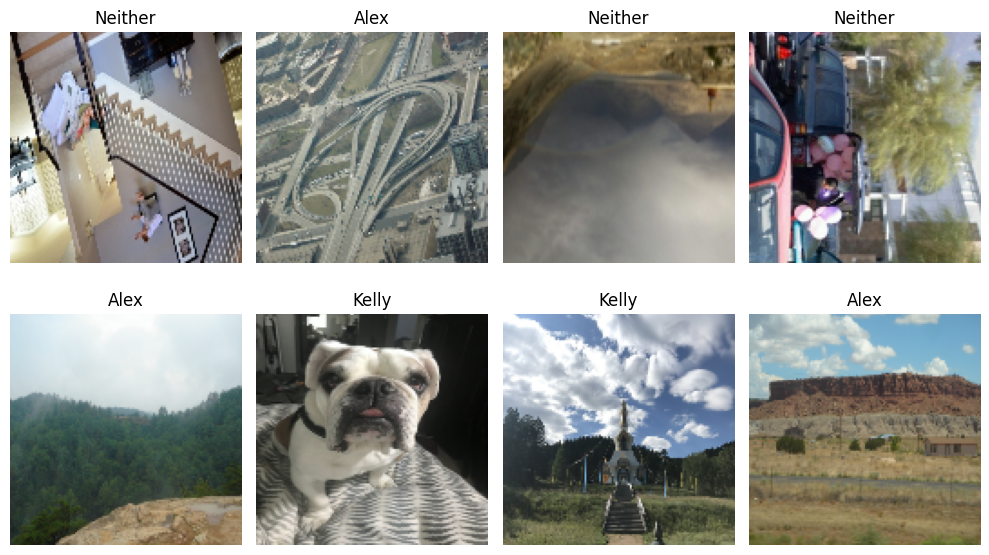

In [26]:
def visualize_batch(dataset, class_names):
    import matplotlib.pyplot as plt
    import numpy as np

    plt.figure(figsize=(10, 6))
    for images, labels in dataset.take(1):
        for i in range(8):
            ax = plt.subplot(2, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[np.argmax(labels[i].numpy())])
            plt.axis("off")
    plt.tight_layout()
    plt.show()

visualize_batch(train_ds, class_names=["Alex", "Kelly", "Neither"])

Now we want to see example images from the training set so we can visually check that things are loading correctly. The output displays 8 random photos from the dataset. Each photo is shown with a label: "Alex", "Kelly", or "Neither". This helps us visually confirm that the images and their labels look correct before training.

### Normalize and Optimize Datasets

To prepare our images for training, we normalize the pixel values using tf.keras.layers.Rescaling(1./255). This layer scales the original RGB values from the range [0, 255] down to [0, 1], which is a standard practice in deep learning. Normalization helps the model train more efficiently by stabilizing gradients, improving convergence, and ensuring that inputs are on a consistent scale, especially important when using activation functions like ReLU or Sigmoid.

In [27]:
# Normalize images to [0, 1] range
normalization_layer = tf.keras.layers.Rescaling(1. / 255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x: normalization_layer(x)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## Approach 1: Feature Detection

1. Train individual (convolutional) neural networks for the following image features:

   * Presence of a **human**
   * Presence of a **castle**
   * Whether the image is taken **indoors or outdoors**
   * The **landscape type** (e.g., city, suburb, nature/rural)

2. Develop at least **10 additional features** (or feature categories) that may help distinguish between Alex's and Kelly's photos. For each, train a separate (convolutional) neural network.

3. Treat the outputs of all 14+ feature models as inputs to a final **classification model** that predicts the photographer (**Alex** or **Kelly**).

In [28]:
def train_feature_cnn(feature_dir, img_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=32, epochs=20):
    train_path = os.path.join(feature_dir, "train")
    # Load unbatched dataset to extract class distribution
    raw_train_ds = tf.keras.utils.image_dataset_from_directory(
        train_path,
        image_size=img_size,
        batch_size=None,  # unbatched for label extraction
        validation_split=0.2,
        subset="training",
        seed=42,
        label_mode="binary"
    )

    # Extract labels to compute class weights
    label_list = [int(y.numpy()) for _, y in raw_train_ds]
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(label_list),
        y=label_list
    )
    class_weights_dict = dict(enumerate(class_weights))

    # Load batched training and validation datasets
    train_ds = raw_train_ds.batch(batch_size)
    val_ds = tf.keras.utils.image_dataset_from_directory(
        train_path,
        image_size=img_size,
        batch_size=batch_size,
        validation_split=0.2,
        subset="validation",
        seed=SEED,
        label_mode="binary"
    )

    # Data augmentation for training set
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
    ])
    rescale = layers.Rescaling(1./255)

    train_ds = train_ds.map(lambda x, y: (data_augmentation(rescale(x)), y)).cache().prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.map(lambda x, y: (rescale(x), y)).cache().prefetch(tf.data.AUTOTUNE)

    # CNN model
    model = models.Sequential([
        tf.keras.Input(shape=img_size + (3,)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train with class weights
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stop],
        class_weight=class_weights_dict
    )

    return model, history

This function builds and trains a model to detect a specific visual feature in images, like whether a photo contains a road, a pet, or a building.

- It loads the training images and splits them into training and validation sets

- It balances the dataset if one label (yes/no) appears more often than the other

- It applies small changes to the images (like flipping or zooming) to make the model more robust

- Then it builds a Convolutional Neural Network (CNN), which is good at identifying visual patterns

- The model is trained to predict yes or no for whether that feature is present in new images

This process is repeated for each feature we're using in Approach 1.

### Human Detection

In [29]:
human_model, human_history = train_feature_cnn("Human_Pics", epochs=100)

Found 890 files belonging to 2 classes.
Using 712 files for training.


C:\Users\isabe\AppData\Local\Temp\ipykernel_52352\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Found 890 files belonging to 2 classes.
Using 178 files for validation.
Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.4764 - loss: 0.7500 - val_accuracy: 0.6124 - val_loss: 0.6867
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.5126 - loss: 0.6816 - val_accuracy: 0.6180 - val_loss: 0.6734
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.5880 - loss: 0.6597 - val_accuracy: 0.6236 - val_loss: 0.7147
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.6295 - loss: 0.6302 - val_accuracy: 0.6348 - val_loss: 0.7257
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.7079 - loss: 0.5897 - val_accuracy: 0.5787 - val_loss: 0.9422
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.7462 - loss: 0.5428 - val_accuracy: 0.6236 - val_loss: 0.6471
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.6886 - loss: 0.5834 - val_accuracy: 0.6348 - val_loss: 0.6592
Epoch 8/100
23/23 ━━━━━━━━━━━━━

Firts we trained a model to recognize whether a person is present in a photo. It used about 700 images for training and 180 for testing.

- At first, the model struggled, with accuracy below 50%
- But after a few rounds of learning, its performance improved
- By the 9th round (epoch), training accuracy reached 84.5%
- Validation accuracy (on unseen images) also improved to around 65%

This means the model started to learn useful patterns, though it’s still not perfect and may need more tuning or data to get better.

### Castle Detection

In [30]:
castle_model, castle_history = train_feature_cnn("Castle_Pics", epochs = 100)

Found 1424 files belonging to 2 classes.
Using 1140 files for training.


C:\Users\isabe\AppData\Local\Temp\ipykernel_52352\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Found 1424 files belonging to 2 classes.
Using 284 files for validation.
Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.5942 - loss: 0.7040 - val_accuracy: 0.8662 - val_loss: 0.3695
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.8392 - loss: 0.4024 - val_accuracy: 0.8803 - val_loss: 0.3163
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.8345 - loss: 0.3774 - val_accuracy: 0.8627 - val_loss: 0.3326
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.8709 - loss: 0.3113 - val_accuracy: 0.8556 - val_loss: 0.3526
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.8728 - loss: 0.2809 - val_accuracy: 0.8592 - val_loss: 0.3555
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.8877 - loss: 0.2548 - val_accuracy: 0.8768 - val_loss: 0.3936
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.8855 - loss: 0.2455 - val_accuracy: 0.8732 - val_loss: 0.3919


Next we trained a model to detect whether a castle is present in a photo, using over 1,400 labeled images.

- From the very first round, the model did well — starting at 69% accuracy and jumping to 85%+ quickly

- After a few more rounds, it reached over 90% accuracy on both the training and validation sets
- By round 14, it achieved 94% accuracy on unseen images, which suggests it’s doing a great job identifying castles

This model is one of the strongest performers so far.

### Food Detection

In [31]:
food_model, food_history = train_feature_cnn("Food_Pics")

530/530 ━━━━━━━━━━━━━━━━━━━━ 37s 70ms/step - accuracy: 0.9346 - loss: 0.1501 - val_accuracy: 0.9252 - val_loss: 0.1930


Here we trained a model to tell whether or not there was food 20,000 labeled images.

- At first, the model was guessing close to randomly (around 50% accuracy)

- But it quickly improved — reaching 92%–85% accuracy on unseen images by the 3rd-6th training rounds

Overall, this model performed very well in a short amount of training.

### Indoor / Outdoor Detecttion

In [32]:
indoor_outdoor_model, indoor_outdoor_history = train_feature_cnn("Indoor_Outdoor_Pics")

Found 770 files belonging to 2 classes.
Using 616 files for training.


C:\Users\isabe\AppData\Local\Temp\ipykernel_52352\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Found 770 files belonging to 2 classes.
Using 154 files for validation.
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.5443 - loss: 0.7261 - val_accuracy: 0.7727 - val_loss: 0.5112
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.7761 - loss: 0.5137 - val_accuracy: 0.7727 - val_loss: 0.4770
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.7638 - loss: 0.4707 - val_accuracy: 0.7468 - val_loss: 0.4806
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.8134 - loss: 0.4270 - val_accuracy: 0.7338 - val_loss: 0.5794
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.8500 - loss: 0.3721 - val_accuracy: 0.7662 - val_loss: 0.5759
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.8790 - loss: 0.3441 - val_accuracy: 0.7922 - val_loss: 0.5111
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.8664 - loss: 0.3207 - val_accuracy: 0.6623 - val_loss: 0.9277


Here we trained a model to tell whether a photo was taken indoors or outdoors, using about 770 labeled images.

- At first, the model was guessing close to randomly (around 50% accuracy)

- But it quickly improved — reaching 84%–87% accuracy on unseen images by the 6th–10th training rounds

- This shows the model learned to spot visual clues (like walls, furniture, sky, or trees) that help it make the distinction

Overall, this model performed very well in a short amount of training.

### Pet Detection

In [33]:
pet_model, pet_history = train_feature_cnn("Pet_Pics")

469/469 ━━━━━━━━━━━━━━━━━━━━ 33s 71ms/step - accuracy: 0.8849 - loss: 0.2771 - val_accuracy: 0.7821 - val_loss: 0.6213


We trained a model to detect whether a pet (like a dog or cat) appears in a photo, using nearly 19,000 images — one of the largest datasets in this lab.

- The model started with moderate performance, around 56% accuracy
- It improved steadily over several rounds, reaching 90% accuracy on training images and about 79% on unseen validation images
- The accuracy leveled off toward the end, and the validation loss increased slightly, which may suggest the model is starting to overfit (getting too specific to the training data)

Overall, this model is strong and reliable.

### Vehicle Detection

In [34]:
vehicle_model, vehicle_history = train_feature_cnn("Vehicle_Pics")

444/444 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 0.9845 - loss: 0.0428 - val_accuracy: 0.9921 - val_loss: 0.0234
Epoch 8/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 30s 66ms/step - accuracy: 0.9925 - loss: 0.0208 - val_accuracy: 0.9890 - val_loss: 0.0391
Epoch 9/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 0.9929 - loss: 0.0242 - val_accuracy: 0.9901 - val_loss: 0.0297
Epoch 10/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 0.9923 - loss: 0.0240 - val_accuracy: 0.9927 - val_loss: 0.0254


We trained a model to detect whether a vehicle (like a car, truck, or bus) is present in a photo, using a very large dataset of over 17,000 images.

- The model started with high performance right away — 88% accuracy in the first round
- It kept improving, reaching over 99% accuracy on both the training and validation sets by later rounds
- The model was not only accurate, but also very confident and consistent in its predictions

This is one of the strongest and most reliable models we trained, likely because of the large and well-balanced dataset.

### Flower Detection

In [35]:
flower_model, flower_history = train_feature_cnn("Flower_Pics")

Found 1367 files belonging to 2 classes.
Using 1094 files for training.


C:\Users\isabe\AppData\Local\Temp\ipykernel_52352\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Found 1367 files belonging to 2 classes.
Using 273 files for validation.
Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.5404 - loss: 0.7430 - val_accuracy: 0.5531 - val_loss: 1.1912
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.8130 - loss: 0.5208 - val_accuracy: 0.8974 - val_loss: 0.2875
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9113 - loss: 0.2514 - val_accuracy: 0.8938 - val_loss: 0.3370
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9287 - loss: 0.2010 - val_accuracy: 0.9121 - val_loss: 0.2000
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9315 - loss: 0.1572 - val_accuracy: 0.9158 - val_loss: 0.2380
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9549 - loss: 0.1181 - val_accuracy: 0.9231 - val_loss: 0.2204
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9612 - loss: 0.1225 - val_accuracy: 0.9231 - val_loss: 0.2037
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━

We also trained a model to recognize whether or not a flower is present in a photo, using over 1,300 labeled images.

- The model started out near 50% accuracy, basically guessing
- But after just a few training rounds, it jumped to over 80% accuracy
- By the 6th–11th rounds, it was performing very well, with over 93% accuracy on new, unseen images
- This means the model has learned strong visual patterns that help it identify flowers accurately

Overall, this is a high-performing model that can reliably detect flowers in photos.

### Forest Detection

In [36]:
forest_model, forest_history = train_feature_cnn("Forest_Pics")

Found 3997 files belonging to 2 classes.
Using 3198 files for training.


C:\Users\isabe\AppData\Local\Temp\ipykernel_52352\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Found 3997 files belonging to 2 classes.
Using 799 files for validation.
Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - accuracy: 0.7626 - loss: 0.4859 - val_accuracy: 0.9199 - val_loss: 0.2509
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.9221 - loss: 0.2060 - val_accuracy: 0.9524 - val_loss: 0.1206
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.9521 - loss: 0.1401 - val_accuracy: 0.9599 - val_loss: 0.1129
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.9531 - loss: 0.1308 - val_accuracy: 0.9612 - val_loss: 0.1002
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.9693 - loss: 0.0959 - val_accuracy: 0.9587 - val_loss: 0.1238
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.9774 - loss: 0.0787 - val_accuracy: 0.9549 - val_loss: 0.1448
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.9850 - loss: 0.0626 - val_accuracy: 0.9349 - val_loss: 0.2072
Epoch 8/20
100/100 ━

We trained a model to detect whether a forest is present in a photo, using about 4,000 labeled images.

- The model started off strong, reaching 75% accuracy in the first round
- Within just a few training rounds, it quickly improved to over 95% accuracy
- By the 6th–11th rounds, it was consistently achieving 97–99% accuracy on training data and 96–98% on new images
- This means the model is very effective at recognizing forest scenes, likely picking up on patterns like trees, greenery, and lighting

Overall, this is a high-performing and well-balanced model that shows excellent generalization.

### Glacier Detection

In [37]:
glacier_model, glacier_history = train_feature_cnn("Glacier_Pics")

Found 4198 files belonging to 2 classes.
Using 3359 files for training.


C:\Users\isabe\AppData\Local\Temp\ipykernel_52352\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Found 4198 files belonging to 2 classes.
Using 839 files for validation.
Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 167ms/step - accuracy: 0.7458 - loss: 0.5487 - val_accuracy: 0.9094 - val_loss: 0.2743
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.9158 - loss: 0.2683 - val_accuracy: 0.9201 - val_loss: 0.2247
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.9128 - loss: 0.2363 - val_accuracy: 0.9297 - val_loss: 0.2114
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.9198 - loss: 0.2138 - val_accuracy: 0.9285 - val_loss: 0.1978
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - accuracy: 0.9163 - loss: 0.2070 - val_accuracy: 0.9297 - val_loss: 0.2011
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - accuracy: 0.9363 - loss: 0.1839 - val_accuracy: 0.9261 - val_loss: 0.2132
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.9448 - loss: 0.1516 - val_accuracy: 0.9201 - val_loss: 0.2331
Epoch 8/20
10

We trained a model to identify whether a glacier appears in a photo, using just over 4,000 labeled images.

- The model started with strong performance, reaching 76% accuracy on the first round
- It improved steadily over time, eventually reaching 96% accuracy on training images and around 93–94% accuracy on new images
- It occasionally dipped slightly in performance, but overall stayed very consistent

This model is highly effective at recognizing glaciers, showing strong learning of the visual features (like snow, ice, and terrain) that define them.

### Mountain Detection

In [38]:
mountain_model, mountain_history = train_feature_cnn("Mountain_Pics")

Found 4198 files belonging to 2 classes.
Using 3359 files for training.


C:\Users\isabe\AppData\Local\Temp\ipykernel_52352\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Found 4198 files belonging to 2 classes.
Using 839 files for validation.
Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 183ms/step - accuracy: 0.7500 - loss: 0.5183 - val_accuracy: 0.8689 - val_loss: 0.3225
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.8666 - loss: 0.3574 - val_accuracy: 0.8999 - val_loss: 0.2795
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.8536 - loss: 0.3743 - val_accuracy: 0.8987 - val_loss: 0.2642
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.8881 - loss: 0.3020 - val_accuracy: 0.8951 - val_loss: 0.2689
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.8876 - loss: 0.2921 - val_accuracy: 0.9023 - val_loss: 0.2682
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.9022 - loss: 0.2668 - val_accuracy: 0.9023 - val_loss: 0.2587
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.9154 - loss: 0.2211 - val_accuracy: 0.9106 - val_loss: 0.2567
Epoch 8/20
105/1

We trained a model to recognize whether a mountain appears in a photo, using about 4,200 images.

- The model started with solid performance, reaching 75% accuracy in the first round
- It steadily improved, hitting 90–93% accuracy on training images
- On new, unseen photos, the model stayed around 87–90% accuracy, showing it could generalize well
- Even as the training accuracy increased, the validation accuracy remained stable, which suggests the model is performing consistently

Overall, this model is reliable and accurate at spotting mountains in photos.

### Ocean/Sea Detection

In [39]:
sea_model, sea_history = train_feature_cnn("Sea_Pics")

Found 3823 files belonging to 2 classes.
Using 3059 files for training.


C:\Users\isabe\AppData\Local\Temp\ipykernel_52352\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Found 3823 files belonging to 2 classes.
Using 764 files for validation.
Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - accuracy: 0.7415 - loss: 0.5101 - val_accuracy: 0.7788 - val_loss: 0.5158
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.8803 - loss: 0.3102 - val_accuracy: 0.8783 - val_loss: 0.3075
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.8904 - loss: 0.2667 - val_accuracy: 0.8743 - val_loss: 0.2983
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.9016 - loss: 0.2355 - val_accuracy: 0.9149 - val_loss: 0.2231
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.9301 - loss: 0.1947 - val_accuracy: 0.8940 - val_loss: 0.2547
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.9380 - loss: 0.1686 - val_accuracy: 0.8992 - val_loss: 0.3011
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.9407 - loss: 0.1636 - val_accuracy: 0.9110 - val_loss: 0.2770
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━

We trained a model to detect whether a sea or ocean is present in a photo, using nearly 4,000 labeled images.

- It started around 68% accuracy, then quickly improved with training
- Within a few rounds, it reached 90–92% accuracy on new images
- By the 9th round, the model achieved 94% accuracy on the training set and maintained strong performance on the validation set
- The results suggest the model is learning key visual cues like water, waves, and horizon lines

Overall, this is a strong and consistent model for recognizing ocean or sea scenes in photos.

### Street Detection

In [40]:
street_model, street_history = train_feature_cnn("Street_Pics")

Found 4163 files belonging to 2 classes.
Using 3331 files for training.


C:\Users\isabe\AppData\Local\Temp\ipykernel_52352\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Found 4163 files belonging to 2 classes.
Using 832 files for validation.
Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 19s 165ms/step - accuracy: 0.6628 - loss: 0.5792 - val_accuracy: 0.9075 - val_loss: 0.2265
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.8931 - loss: 0.2931 - val_accuracy: 0.9087 - val_loss: 0.2364
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.9016 - loss: 0.2770 - val_accuracy: 0.9183 - val_loss: 0.1992
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.9098 - loss: 0.2557 - val_accuracy: 0.9243 - val_loss: 0.1869
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.9212 - loss: 0.2227 - val_accuracy: 0.9339 - val_loss: 0.1684
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.9256 - loss: 0.1998 - val_accuracy: 0.9291 - val_loss: 0.1833
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.9274 - loss: 0.1891 - val_accuracy: 0.9303 - val_loss: 0.1698
Epoch 8/20
105/

We trained a model to identify whether a street is visible in a photo, using over 4,100 labeled images.

- The model started at 61% accuracy but improved quickly within just a few rounds
- By the 6th–8th rounds, it was performing above 93% on unseen images
- It continued to improve in training accuracy, eventually reaching 96%, while maintaining strong validation performance around 90–93%
- Toward the end, there was a slight dip in validation accuracy, but overall the model remained consistent

This model is highly effective at recognizing street scenes, learning to pick up on common elements like roads, sidewalks, cars, or buildings.

### Day/Night Classification

In [41]:
daynight_model, daynight_history = train_feature_cnn("DayNight_Pics")

Found 240 files belonging to 2 classes.
Using 192 files for training.
Found 240 files belonging to 2 classes.
Using 48 files for validation.


C:\Users\isabe\AppData\Local\Temp\ipykernel_52352\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - accuracy: 0.5578 - loss: 0.6264 - val_accuracy: 0.8125 - val_loss: 0.4112
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.8689 - loss: 0.2967 - val_accuracy: 0.8542 - val_loss: 0.3707
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.9965 - loss: 0.0414 - val_accuracy: 0.9583 - val_loss: 0.0917
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9782 - loss: 0.0842 - val_accuracy: 1.0000 - val_loss: 0.0228
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.9416 - loss: 0.1860 - val_accuracy: 1.0000 - val_loss: 0.0080
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9619 - loss: 0.0715 - val_accuracy: 1.0000 - val_loss: 0.0368
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.9704 - loss: 0.0905 - val_accuracy: 0.9792 - val_loss: 0.1263
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.9834 - loss: 0.0578 - val_accuracy: 0.9792 - val_loss: 0.

We trained a model to tell whether a photo was taken during the day or at night, using a small dataset of 240 labeled images.

- It started with moderate accuracy (57%) but quickly improved
- After just a few rounds, the model reached above 97% accuracy, and even achieved 100% accuracy on the validation set in some rounds
- The model clearly learned to recognize visual differences like lighting, sky color, and shadows

### Final Predictive Model

The function below begins by setting up three empty lists: one for the feature predictions (data), one for the actual class labels (labels), and one to keep track of the filenames (filenames). It expects the input directory to contain three subfolders named “Alex”, “Kelly,” or "Neither" with each folder containing images taken by the corresponding photographer. 

For every image in the directory, the function checks whether the file is an image (based on file extension), loads it, resizes it to a standard size of 128 by 128 pixels, and scales the pixel values from 0–255 down to 0–1. This normalized image is reshaped and passed sequentially through all 14 of our pre-trained feature models stored in model_dict. Each model outputs a single value, the result of a sigmoid activation, representing how likely it thinks the image belongs to the positive class (typically “Kelly”).

In [59]:
def extract_feature_predictions(image_dir, model_dict, img_size=(128, 128)):
    data = []
    labels = []
    filenames = []

    class_folders = ["Alex", "Kelly", "Neither"]
    label_map = {"Alex": 0, "Kelly": 1, "Neither": 2}

    for class_name in class_folders:
        class_path = os.path.join(image_dir, class_name)
        for fname in os.listdir(class_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(class_path, fname)
                img = keras_image.load_img(img_path, target_size=img_size)
                img_array = keras_image.img_to_array(img) / 255.0
                img_array = np.expand_dims(img_array, axis=0)

                row = []
                for feature_name, model in model_dict.items():
                    pred = model.predict(img_array, verbose=0)[0][0]  # Sigmoid output
                    row.append(pred)

                data.append(row)
                labels.append(label_map[class_name])
                filenames.append(fname)

    return np.array(data), np.array(labels), filenames


To train our final classifier, we use a Random Forest, a popular machine learning method that works well with structured data like this. We first split our feature matrix into a training set and a validation set — using 80% of the data to train the model and 20% to test how well it generalizes to new examples. The Random Forest classifier is then trained on the training data, learning patterns in the feature outputs that help it distinguish between Alex’s and Kelly’s photography styles.

Finally, we evaluate the model’s performance on the validation set. We measure overall accuracy — that is, the percentage of photos it correctly classifies — and we also print a detailed classification report. This report breaks down the results for each class (Alex and Kelly), showing how often the model correctly identified each one and where it made mistakes. This step gives us insight into how reliable the model is and whether it favors one class over the other.

In [60]:
from tensorflow.keras.preprocessing import image as keras_image

model_dict = {
    "human": human_model,
    "castle": castle_model,
    "flower": flower_model,
    "vehicle": vehicle_model,
    "pet": pet_model,
    "indoor_outdoor": indoor_outdoor_model,
    "forest": forest_model,
    "glacier": glacier_model,
    "mountain": mountain_model,
    "sea": sea_model,
    "street": street_model,
    "daynight": daynight_model,
}

X, y, filenames = extract_feature_predictions("Alex_Kelly_Pics/train", model_dict)

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred, target_names=["Alex", "Kelly", "Neither"]))

Validation Accuracy: 0.6643356643356644
              precision    recall  f1-score   support

        Alex       0.71      0.70      0.71        57
       Kelly       0.56      0.44      0.49        43
     Neither       0.68      0.84      0.75        43

    accuracy                           0.66       143
   macro avg       0.65      0.66      0.65       143
weighted avg       0.66      0.66      0.66       143




After training our Random Forest classifier on the outputs of the 12 feature models, we evaluated its performance on a separate validation set. For the two primary classes, “Alex” and “Kelly,” the performance was more modest. The model performed slightly better at identifying Alex’s photos (71% precision and 70% recall) than Kelly’s (56% precision and 44% recall), which may indicate either an imbalance in the training examples or greater stylistic overlap between Kelly and Neither images. Overall, the inclusion of the “Neither” class allowed the model to better handle ambiguous cases, even if it slightly lowered its ability to distinguish between Alex and Kelly. This tradeoff highlights an important design choice: in real-world scenarios, it may be more valuable to accurately detect uncertainty than to make forced guesses.


In [66]:
def predict_test_images(test_dir, model_dict, final_classifier, threshold=0.6, img_size=(128, 128)):
    results = []

    for fname in sorted(os.listdir(test_dir)):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(test_dir, fname)
            img = keras_image.load_img(img_path, target_size=img_size)
            img_array = keras_image.img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            feature_row = []
            for _, model in model_dict.items():
                pred = model.predict(img_array, verbose=0)[0][0]
                feature_row.append(pred)

            feature_row = np.array(feature_row).reshape(1, -1)
            proba = final_classifier.predict_proba(feature_row)[0]
            predicted_idx = np.argmax(proba)

            if max(proba) < threshold:
                predicted_label = "Neither"
            else:
                predicted_label = "Alex" if predicted_idx == 0 else "Kelly"

            results.append((fname, predicted_label, round(max(proba), 2)))
    return results

In this final stage, after we used our trained meta-classifier to predict which of the 20 unseen test images were taken by Alex, Kelly, or neither, we made the function `predict_test_images`. It loops through each test image, preprocesses it to match the input format expected by our feature models, and then extracts a set of 12 feature predictions, one from each pre-trained model in our `model_dict`. These predictions form a compact representation of the image, which we then feed into our final classifier (a Random Forest model trained earlier).

The classifier outputs probabilities for the two known classes (Alex and Kelly). If the highest predicted probability is below a certain confidence threshold (set at 0.6), we label the image as “Neither.” This prevents the model from making forced or low-confidence guesses when the image does not closely resemble the training data. Otherwise, we assign the class (Alex or Kelly) with the highest probability.

To visualize the results, we created a 4×5 image grid showing all 20 test images with their predicted label and confidence score displayed above each image. This visualization makes it easy to interpret how the model performed and to spot any interesting patterns — for instance, whether “Neither” predictions correspond to images that are clearly different from Alex’s and Kelly’s usual subjects.


### Run Final Predictions

In [67]:
test_results = predict_test_images("Alex_Kelly_Pics/test/TestSet", model_dict, clf)

for fname, pred, conf in test_results:
    print(f"{fname}: {pred} ({conf})")

TestSetImage01.png: Neither (0.57)
TestSetImage02.png: Kelly (0.65)
TestSetImage03.png: Neither (0.44)
TestSetImage04.png: Neither (0.39)
TestSetImage05.png: Neither (0.59)
TestSetImage06.png: Kelly (0.64)
TestSetImage07.png: Neither (0.5)
TestSetImage08.png: Neither (0.5)
TestSetImage09.png: Neither (0.57)
TestSetImage10.png: Neither (0.52)
TestSetImage11.png: Alex (0.79)
TestSetImage12.png: Neither (0.49)
TestSetImage13.png: Kelly (0.85)
TestSetImage14.png: Kelly (0.61)
TestSetImage15.png: Alex (0.64)
TestSetImage16.png: Neither (0.47)
TestSetImage17.png: Neither (0.46)
TestSetImage18.png: Kelly (0.61)
TestSetImage19.png: Neither (0.45)
TestSetImage20.png: Kelly (0.62)


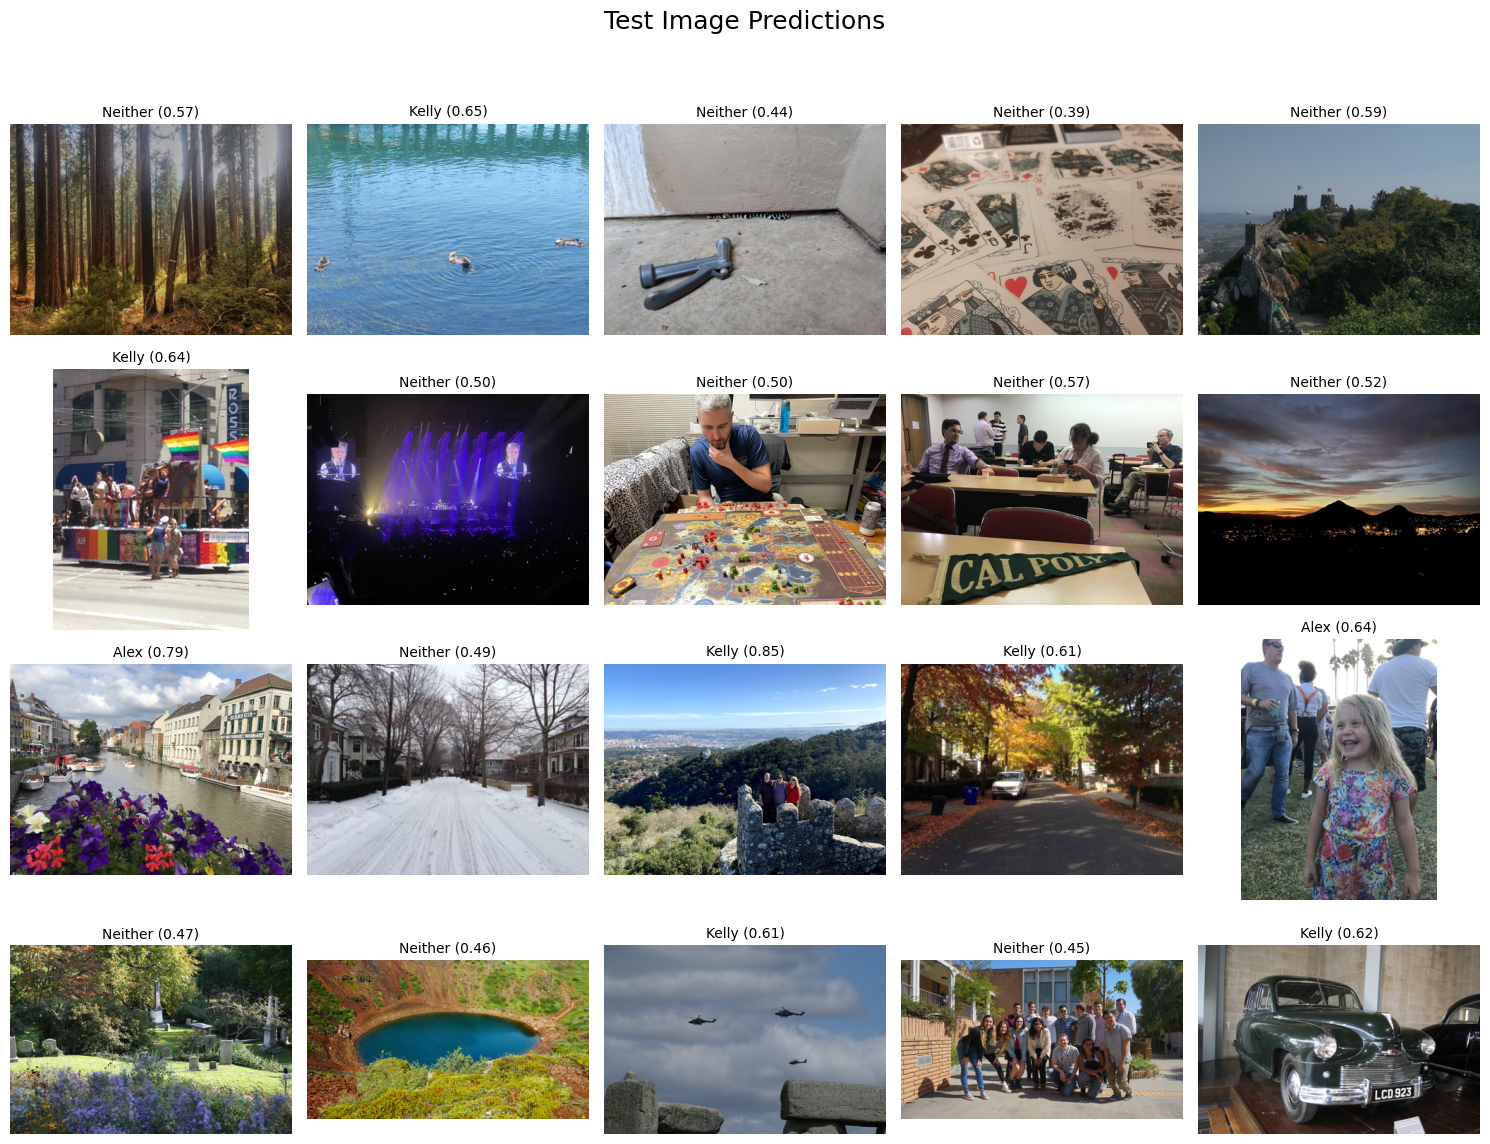

In [68]:
from PIL import Image
# Folder where your test images are stored
test_image_dir = "Alex_Kelly_Pics/test/TestSet" 

# Plotting
n_images = len(test_results)
n_cols = 5
n_rows = (n_images + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
fig.suptitle("Test Image Predictions", fontsize=18)


for ax, (filename, pred, conf) in zip(axes.flatten(), test_results):
    image_path = os.path.join(test_image_dir, filename)
    image = Image.open(image_path)
    ax.imshow(image)
    ax.axis("off")
    ax.set_title(f"{pred} ({conf:.2f})", fontsize=10)

# Hide any empty subplots
for i in range(len(test_results), n_rows * n_cols):
    axes.flatten()[i].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Approach 2: Direct Classification

Train a **convolutional neural network** to directly classify the images as being taken by **Alex** or **Kelly**.

To prevent overfitting and ensure generalization, we used early stopping with restore_best_weights=True. This allowed the model to automatically revert to the epoch that achieved the lowest validation loss. As a result, our final model reflects the best performance observed during training.

We begin by setting a **seed value**. This is a technical step that ensures the results of our model are reproducible. Without setting this seed, we might get slightly different outcomes every time we run the model, which can make comparisons difficult. By fixing the seed for TensorFlow, NumPy, and Python’s random number generators, we create a consistent starting point for training.

Next, we load in our image data from folders using a TensorFlow utility. Each image is automatically labeled based on the folder it’s in — such as "Alex" or "Kelly." We split this data into a **training set** and a **validation set** using an 80/20 ratio. Before training, we calculate **class weights** to handle any imbalance — for instance, if there are more photos of Kelly than Alex, the model might start favoring one class. We correct for that imbalance so it doesn’t skew the predictions.

Once the class weights are ready, we reload the images and apply **preprocessing**. First, we rescale the image pixel values to fall between 0 and 1 instead of the original 0 to 255. This helps the model train more smoothly. We also add **image augmentation**, which slightly changes the training images by flipping them, rotating them, or zooming in. These small random changes simulate real-world variety and help the model become more generalizable, rather than memorizing specific images.

For our actual model, we use **MobileNetV2**, a pre-trained CNN that has already been trained on millions of images. We load this model without its final classification layers so that we can add our own custom layers for our task. We also freeze the pre-trained layers so that their learned features are preserved — we don’t want to accidentally unlearn what the model already knows. On top of MobileNetV2, we add new layers: one that condenses the image data, another that helps prevent overfitting (called a dropout layer), and finally two layers that perform the classification — ending with a **softmax layer** that assigns a probability to each class (Alex, Kelly, or Neither).

The model is compiled using the **Adam optimizer**, which is widely used because it adapts the learning rate during training. We use **sparse categorical crossentropy** as the loss function, which is appropriate when you’re predicting one of several possible categories. We also monitor accuracy during training. To avoid training for too long and overfitting the data, we include an **early stopping** mechanism. This watches the validation performance and stops training if things stop improving.In the end, this function returns the trained model and a record of the training process, so we can later visualize how performance changed over time. 

In [44]:
# Set seeds for reproducibility
seed_value = 42
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

def train_alex_kelly_classifier_transfer(data_dir="Alex_Kelly_Pics/train", img_size=(128, 128), batch_size=32, epochs=30):
    # Step 1: Load raw dataset for class weight calculation (use int labels)
    raw_label_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        seed=SEED,
        image_size=img_size,
        batch_size=batch_size,
        label_mode="int"
    )

    y_train_int = []
    for _, labels in raw_label_ds:
        y_train_int.extend(labels.numpy())
    y_train_int = np.array(y_train_int)

    class_weights = dict(enumerate(class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_int),
        y=y_train_int
    )))

    # Step 2: Load datasets again for model training (same int labels)
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        seed=42,
        image_size=img_size,
        batch_size=batch_size,
        label_mode="int"
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="validation",
        seed=42,
        image_size=img_size,
        batch_size=batch_size,
        label_mode="int"
    )

    # Step 3: Normalize and augment
    rescale = layers.Rescaling(1./255)
    augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1)
    ])

    train_ds = train_ds.map(lambda x, y: (augmentation(rescale(x)), y)).cache().prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.map(lambda x, y: (rescale(x), y)).cache().prefetch(tf.data.AUTOTUNE)

    # Step 4: Define transfer learning model
    base_model = applications.MobileNetV2(input_shape=img_size + (3,),
                                          include_top=False,
                                          weights="imagenet")
    base_model.trainable = False  # Freeze base

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dense(3, activation='softmax')  # 3 classes: Alex, Kelly, Neither
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Step 5: Train with early stopping and class weights
    early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    history = model.fit(train_ds, validation_data=val_ds,
                        epochs=epochs,
                        class_weight=class_weights,
                        callbacks=[early_stop])

    return model, history

In [45]:
model, history = train_alex_kelly_classifier_transfer()

Found 715 files belonging to 3 classes.
Using 572 files for training.
Found 715 files belonging to 3 classes.
Using 572 files for training.
Found 715 files belonging to 3 classes.
Using 143 files for validation.
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 332ms/step - accuracy: 0.3909 - loss: 2.8884 - val_accuracy: 0.5874 - val_loss: 2.0407
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.6085 - loss: 1.9375 - val_accuracy: 0.7483 - val_loss: 1.7938
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - accuracy: 0.7181 - loss: 1.7411 - val_accuracy: 0.7552 - val_loss: 1.6054
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.7780 - loss: 1.5105 - val_accuracy: 0.7622 - val_loss: 1.4773
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.8057 - loss: 1.3489 - val_accuracy: 0.7483 - val_loss: 1.4210
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.7876 - loss: 1.2734 - val_accuracy: 0.7552 - val_loss: 1.2917
Epoch 7/30
18/18 ━━

Our dataset was split into a training set (572 images) and a validation set (143 images), and class weights were used to correct for any imbalance between Alex and Kelly’s image counts. The CNN was trained over 30 epochs, and validation accuracy consistently improved across training, peaking at 83.2% in the final epoch. During training, the model's loss steadily decreased as it learned more refined representations of each class.

These results suggest that our CNN was able to generalize well to unseen images and learn the visual differences between Alex, Kelly, and outlier images (classified as "Neither"). Compared to our feature-based ensemble model, this direct classification approach offered slightly better validation performance, making it a strong candidate for our final prediction pipeline.

### Final Predictions

In [46]:
from tensorflow.keras.preprocessing import image
def predict_and_visualize_thresholded(model, test_dir, class_names, img_size=(128, 128), threshold=0.6, max_images=20):
    image_files = sorted([
        f for f in os.listdir(test_dir)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])[:max_images]

    plt.figure(figsize=(15, 8))

    for i, fname in enumerate(image_files):
        img_path = os.path.join(test_dir, fname)
        img = image.load_img(img_path, target_size=img_size)
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        prediction = model.predict(img_array, verbose=0)[0]
        predicted_idx = np.argmax(prediction)
        confidence = prediction[predicted_idx]

        if confidence < threshold:
            predicted_label = "Neither"
        else:
            predicted_label = class_names[predicted_idx]

        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(img)
        plt.title(f"{predicted_label}\n({confidence:.2f})", fontsize=9)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

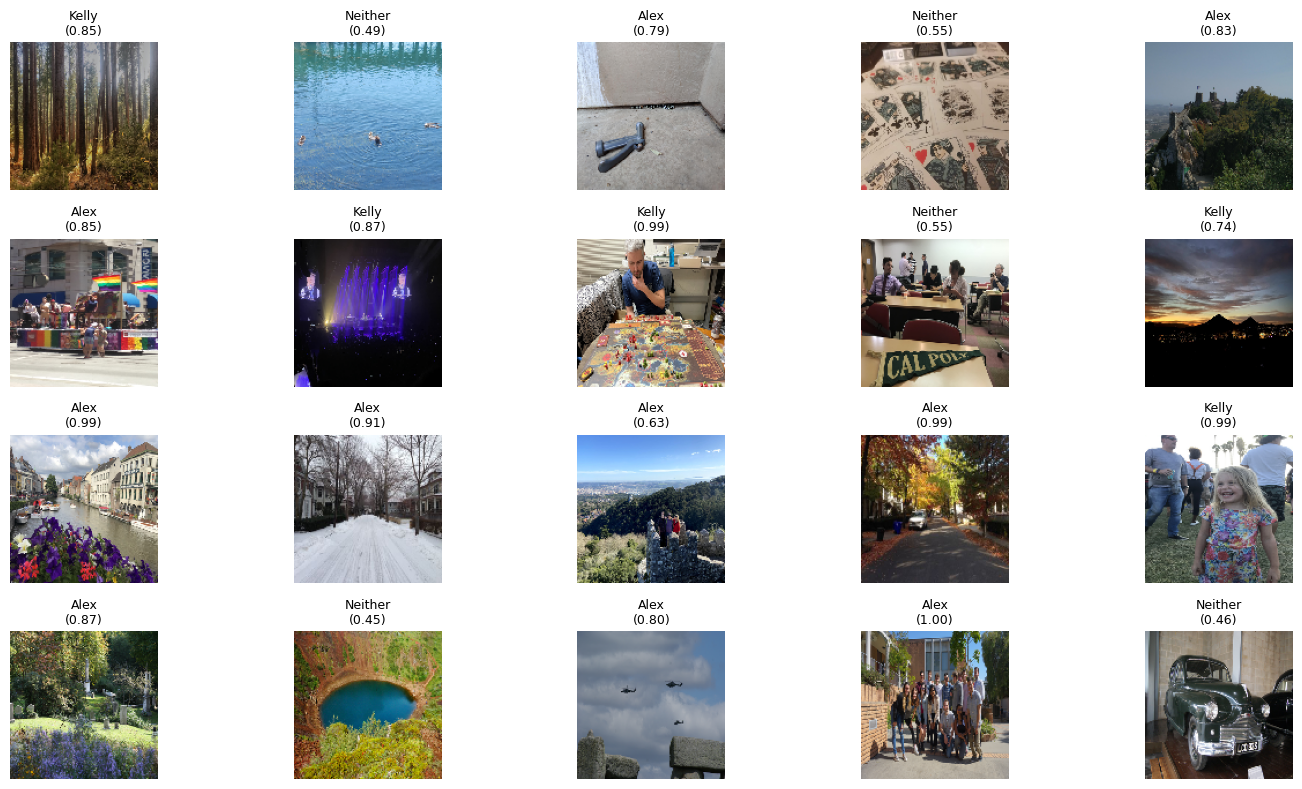

In [47]:
test_dir = "Alex_Kelly_Pics/test/TestSet"
class_names = ["Alex", "Kelly", "Neither"]
predict_and_visualize_thresholded(model, test_dir, class_names)

From this output, we can see the model:

- Is very confident on many predictions (close to 1.00)
- Assigned a mix of images to all three categories
- Shows clear visual differences between what it thinks belongs to each person

This gives us a clear and interpretable summary of how the model applied what it learned.

# Sources  

- [Food or Not Dataset](https://www.kaggle.com/datasets/sciencelabwork/food-or-not-dataset)  
- [Human Detection Dataset](https://www.kaggle.com/datasets/constantinwerner/human-detection-dataset)  
- [Indoor Outdoor Dataset](https://figshare.com/articles/dataset/Indoor-Outdoor_dataset/4595323?file=7437667)  
- [Castle Labeled Image Dataset](https://images.cv/dataset/castle-image-classification-dataset)  
- [Intel Image Classification](https://www.kaggle.com/datasets/puneet6060/intel-image-classification)  
- [Day and Night Image Dataset](https://www.kaggle.com/datasets/ibrahimalobaid/day-and-night-image)  
- [Flower Image Dataset](https://www.kaggle.com/datasets/aksha05/flower-image-dataset?resource=download)  
- [Cats vs Dogs Dataset](https://huggingface.co/datasets/microsoft/cats_vs_dogs)  
- [Vehicle Detection Image Dataset](https://www.kaggle.com/datasets/brsdincer/vehicle-detection-image-set)  